In [1]:
# import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from func import plot_pr_rec_curves
import joblib
from IPython.core.display_functions import display
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read and display data
df = pd.read_csv('../data/COVIDandFLUdata.csv')
display(df.head(), df.Diagnosis.value_counts(), df.shape)

,Diagnosis,InitialPCRDiagnosis,Age,Sex,Region,CommunityTransmission,NumberOfFamilyMembersInfected,neutrophil,neutrophilCategorical,serumLevelsOfWhiteBloodCell,...,Temperature,Hematocrit,ActivatedPartialThromboplastinTime,Fibrinogen,Urea,Fatigue,Monocytes,Basophil,Cancer,Thrombocytes
0,H1N1,NaN,67.0,F,NaN,NaN,NaN,NaN,NaN,NaN,...,38.111111,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN
1,H1N1,NaN,29.0,M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H1N1,NaN,22.0,F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H1N1,NaN,20.0,F,NaN,NaN,NaN,NaN,NaN,NaN,...,36.555556,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN
4,H1N1,NaN,21.0,M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


H1N1       1072
COVID19     413
Name: Diagnosis, dtype: int64

(1485, 51)

In [3]:
# Declare the list with categorical features
features_to_encode = ['Sex', 'CTscanResults', 'XrayResults', 'SmokingStatus', 'Diarrhea'
    , 'Fever', 'Coughing', 'ShortnessOfBreath', 'SoreThroat', 'NauseaVomitting', 'Pregnant', 'Fatigue', 'Cancer'
    , 'neutrophilCategorical', 'serumLevelsOfWhiteBloodCellCategorical', 'lymphocytesCategorical', 'CReactiveProteinLevelsCategorical']

In [4]:
# Apply lowercase for categorical data and delete spaces
df[features_to_encode] = df[features_to_encode].astype(str).applymap(str.lower).applymap(str.strip)
df[features_to_encode].head()

,Sex,CTscanResults,XrayResults,SmokingStatus,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Pregnant,Fatigue,Cancer,neutrophilCategorical,serumLevelsOfWhiteBloodCellCategorical,lymphocytesCategorical,CReactiveProteinLevelsCategorical
0,f,nan,nan,nan,nan,yes,yes,nan,no,nan,nan,no,nan,nan,nan,nan,nan
1,m,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,f,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,f,nan,nan,nan,nan,yes,yes,nan,no,nan,nan,yes,nan,nan,nan,nan,nan
4,m,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [5]:
# Create encoded columns for categorical data
for i in features_to_encode:
    df = pd.concat([df, pd.get_dummies(df[i], prefix=i)],axis=1)
df = df.loc[:, ~df.columns.str.endswith('nan')]

In [6]:
# Create a list of features
all_features = list(df.select_dtypes(['float', 'uint8']).columns)
features_to_drop = ['DaysToDeath', 'DaysInIncubation', 'VapingStatus', 'TimeBetweenAdmissionAndDiagnosis']
features = list(set(all_features) - set(features_to_drop))
print(features, '\nlen: ', len(features))

['Fibrinogen', 'neutrophil', 'CTscanResults_pos', 'CTscanResults_inconclusive', 'Sex_m', 'Sex_f', 'Eosinophils', 'Temperature', 'Fatigue_yes', 'Plateletes', 'Thrombocytes', 'SmokingStatus_no', 'DurationOfIllness', 'Urea', 'serumLevelsOfWhiteBloodCell', 'neutrophilCategorical_low', 'CTscanResults_neg', 'neutrophilCategorical_high', 'Fever_no', 'Pregnant_no', 'serumLevelsOfWhiteBloodCellCategorical_high', 'Basophil', 'SmokingStatus_yes', 'ShortnessOfBreath_no', 'serumLevelsOfWhiteBloodCellCategorical_low', 'NauseaVomitting_yes', 'Diarrhea_yes', 'Pregnant_yes', 'SoreThroat_no', 'lymphocytesCategorical_low', 'NauseaVomitting_no', 'ActivatedPartialThromboplastinTime', 'Fever_yes', 'Coughing_no', 'Hematocrit', 'Monocytes', 'CReactiveProteinLevelsCategorical_normal', 'lymphocytesCategorical_high', 'Fatigue_no', 'lymphocytesCategorical_normal', 'Procalcitonin', 'Age', 'ShortnessOfBreath_yes', 'Red blood cells', 'Diarrhea_no', 'Cancer_yes', 'Hemoglobin', 'NumberAffectedLobes', 'Coughing_yes', '

In [7]:
# Formation X dataset with features and y with target column
X = df[features]
X.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
y = (df['Diagnosis'] == 'COVID19') * 1
y.value_counts()

0    1072
1     413
Name: Diagnosis, dtype: int64

In [8]:
# Split dataset for train and test parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Save datasets
X_train['y'] = y_train
X_train.to_csv('../data/train_data.csv', index=False)
X_test['y'] = y_test
X_test.to_csv('../data/test_data.csv', index=False)
X_train.drop(columns='y', inplace=True)
X_test.drop(columns='y', inplace=True)

In [9]:
# Declaration of parameters obtained with Hyperparameters_Tuning notebook
params = {'n_estimators': 400, 'max_features': 10, 'max_depth': 16, 'class_weight': 'balanced'}

In [10]:
# Model training
clf = RandomForestClassifier(**params, n_jobs = -1, random_state = 42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=10,
                       n_estimators=400, n_jobs=-1, random_state=42)

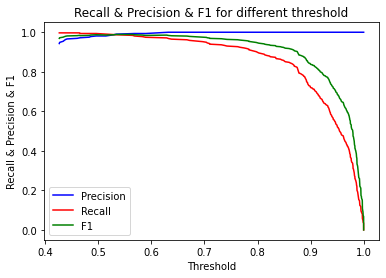

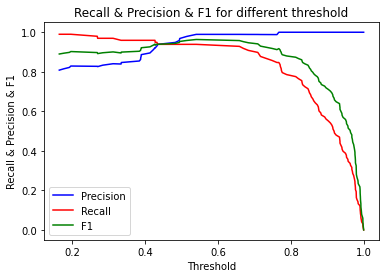

In [11]:
# Get probabilities for train and test datasets and plot Precision, Recall and F1 curves to see the best threshold
proba_train = clf.predict_proba(X_train)[:,1]
proba_test = clf.predict_proba(X_test)[:,1]
plot_pr_rec_curves(y_train, proba_train)
plot_pr_rec_curves(y_test, proba_test)

In [12]:
# Get predictions with the best threshold and print classification report
thr = 0.6
print('Train')
pred_train = (proba_train > thr) * 1
print(classification_report(y_train, pred_train))
print('Test')
pred_test = (proba_test > thr) * 1
print(classification_report(y_test, pred_test))

Train
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       873
           1       0.99      0.97      0.98       315

    accuracy                           0.99      1188
   macro avg       0.99      0.99      0.99      1188
weighted avg       0.99      0.99      0.99      1188

Test
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       199
           1       0.99      0.94      0.96        98

    accuracy                           0.98       297
   macro avg       0.98      0.97      0.97       297
weighted avg       0.98      0.98      0.98       297



<AxesSubplot:>

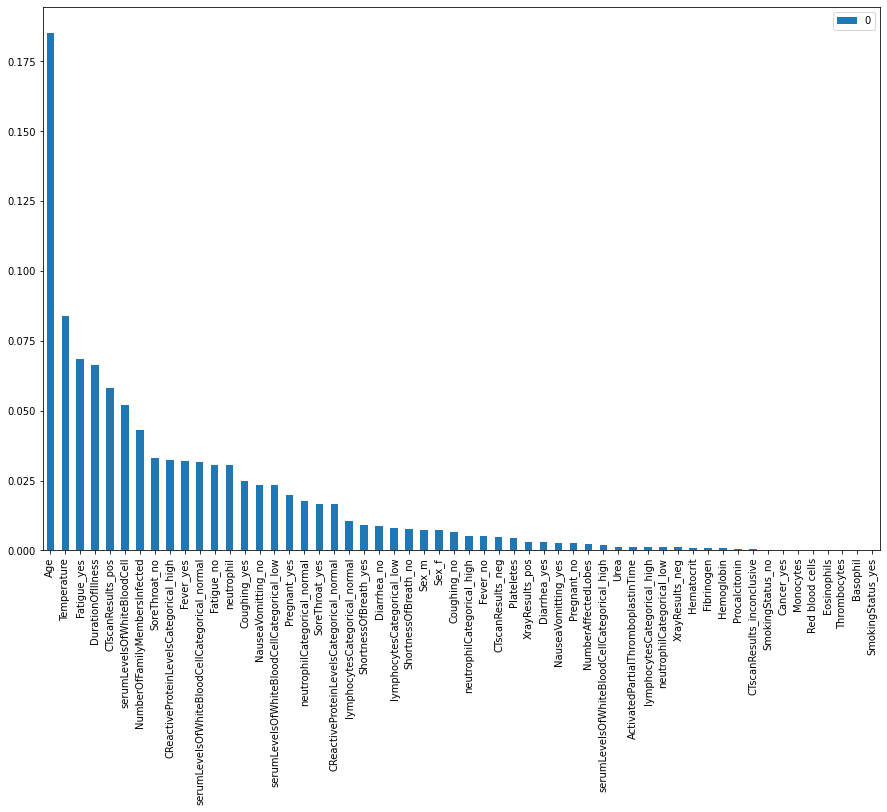

In [13]:
# Get and plot feature importance
importances = list(zip(clf.feature_importances_, X_train.columns))
importances.sort(reverse=True)
pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar', figsize=(15, 10))

In [66]:
# Save model
joblib.dump(clf, "../rf_covid19.joblib")

['rf_covid19.joblib']

In [5]:
# Save model columns
import pickle
with open('../rf_covid19_columns.pkl', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)